In [1]:
import projectpath

import cobra
from collections import defaultdict
import json
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import time
from urllib.request import urlopen

from mosmo.model import Molecule, Reaction, ReactionNetwork
from mosmo.calc import fba_gd

jax.config.update('jax_enable_x64', True)
prng = jax.random.PRNGKey(int(time.time() * 1000))

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## ecoli_core network solved by cobrapy

In [2]:
%%time
# iml1515 = json.loads(urlopen("http://bigg.ucsd.edu/static/models/iML1515.json").read())
model = cobra.io.load_model("textbook")
solution = model.optimize()
model.summary()

CPU times: user 378 ms, sys: 2.54 ms, total: 381 ms
Wall time: 471 ms


Metabolite,Reaction,Flux,C-Number,C-Flux
glc__D_e,EX_glc__D_e,10,6,100.00%
nh4_e,EX_nh4_e,4.765,0,0.00%
o2_e,EX_o2_e,21.8,0,0.00%
pi_e,EX_pi_e,3.215,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,-22.81,1,100.00%
h2o_e,EX_h2o_e,-29.18,0,0.00%
h_e,EX_h_e,-17.53,0,0.00%


## Construct the same FBA problem using ReactionNetwork and FbaGd

In [4]:
def mol_from_cobra(cobra_mol):
    return Molecule(
        id=cobra_mol.id,
        name=cobra_mol.name,
        formula=cobra_mol.formula,
        charge=cobra_mol.charge,
    )

def reaction_from_cobra(cobra_reaction, mol_lookup):
    return Reaction(
        id=cobra_reaction.id,
        name=cobra_reaction.name,
        stoichiometry={mol_lookup[mol.id]: count for mol, count in cobra_reaction.metabolites.items()},
        reversible=cobra_reaction.reversibility,
    )

mols = {}
for cobra_mol in model.metabolites:
    mol = mol_from_cobra(cobra_mol)
    mols[mol.id] = mol

reactions = {}
bounds = {}
biomass = {}
for cobra_reaction in model.reactions:
    # bigg and cobra mix in regular reactions, exhanges, and biomass. We treat them separately.
    if len(cobra_reaction.metabolites) == 1:
        mol = mols[next(iter(cobra_reaction.metabolites)).id]
        # print(f"{cobra_reaction.id}: {mol} {cobra_reaction.bounds}")
        bounds[mol] = cobra_reaction.bounds
    elif cobra_reaction.id.lower().startswith("biomass_"):
        biomass[cobra_reaction.id] = {mols[component.id]: -amount for component, amount in cobra_reaction.metabolites.items()}
    else:
        rxn = reaction_from_cobra(cobra_reaction, mols)
        reactions[rxn.id] = rxn
print(f"{len(reactions)} reactions on {len(mols)} molecules; {len(bounds)} boundary molecules; {len(biomass)} biomass compositions")

network = ReactionNetwork(reactions.values())
print(f"network shape: {network.shape}")

74 reactions on 72 molecules; 20 boundary molecules; 1 biomass compositions
network shape: (72, 74)


### Basic constraints
- SteadyStateObjective for internal (non-boundary, _non-biomass_) reactants
- ProductionObjective (maybe rethink the name...) for boundaries/exchanges

In [5]:
biomass_components = biomass["Biomass_Ecoli_core"]
intermediates = set(network.reactants) - bounds.keys() - biomass_components.keys()
ss_constraint = fba_gd.SteadyStateObjective(network, intermediates)
exchange_constraint = fba_gd.ProductionObjective(network, bounds)

print(f"{len(intermediates)} intermediates, {len(bounds)} boundaries with constraints, {len(biomass_components)} biomass components")

29 intermediates, 20 boundaries with constraints, 23 biomass components


- An alternative approach would be to explicitly treat +/- 1000 as unbounded, and include only what's left. Let's do that.

In [6]:
constraints = {}
for mol, (lb, ub) in bounds.items():
    lb = None if lb == -1000 else lb
    ub = None if ub == 1000 else ub
    if lb is not None or ub is not None:
        constraints[mol] = (lb, ub)
print(len(bounds), len(constraints))
exchange_constraint = fba_gd.ProductionObjective(network, constraints)

20 14


### New to FbaGd: an objective to maximize biomass growth
- Probably want to avoid least_squares(), and instead use minimize() while tweaking weights and l1v s l2
- Ease into it first: use a ProductionObjective with specific targets for biomass, based on the cobrapy solution.

In [7]:
growth = solution.objective_value
biomass_objective = fba_gd.ProductionObjective(network, {component: growth * amount for component, amount in biomass_components.items()})

Since we're using specific targets that are known to be achievable we should be able to get away with weighting all the objectives equally. But anticipating when the biomass objective is controlled by a variable to be optimized to a non-zero value, we should also look at how changing its weight affects the outcome

In [8]:
%%time
problem = fba_gd.FbaGd(
    network, intermediates, {
        # "steady-state": ss_constraint,  # Forgot the ss constraint is automatic.
        "constraints": exchange_constraint,
        "growth": biomass_objective,
    },
    w_fitness=1e4,
)
gd_soln = problem.solve()
print(gd_soln.fit)

1.182151282160716e-20
CPU times: user 761 ms, sys: 473 ms, total: 1.23 s
Wall time: 563 ms


## Comparisons

In [9]:
def labels(entries):
    return [entry.label for entry in entries]

fluxv_cobra = np.array(solution.fluxes[labels(network.reactions)])
fluxv_gd = gd_soln.velocities

flux_df = pd.DataFrame({
    rxn.id: {"cobra": flux_cobra, "fbagd": flux_gd}
    for rxn, flux_cobra, flux_gd in zip(network.reactions, fluxv_cobra, fluxv_gd)}).T

dmdtv_cobra = network.s_matrix @ fluxv_cobra
dmdtv_gd = gd_soln.dmdt

dmdt_df = pd.DataFrame({
    mol.id: {"cobra": dmdt_cobra, "fbagd": dmdt_gd}
    for mol, dmdt_cobra, dmdt_gd in zip(network.reactants, dmdtv_cobra, dmdtv_gd)}).T

### Assessment of steady state

In [10]:
(dmdt_df.loc[labels(intermediates)]**2).sum()

cobra    5.302964e-28
fbagd    8.244306e-23
dtype: float64

### Agreement on exchanges/boundaries

<Axes: >

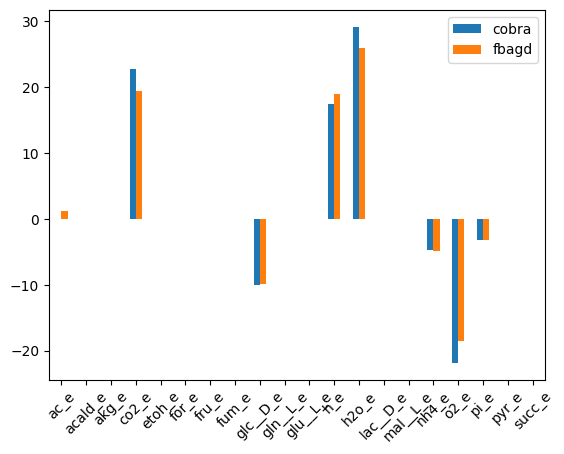

In [11]:
dmdt_df.loc[labels(bounds.keys())].plot.bar(rot=45)

Overall assessment: general agreement, but not identical. We seem to find a slightly less aerobic solution with the same growth rate.
- ATP in excess?
- Higher rate possible?
- Glc, NH4, and PO4 are all at max uptake, is it NH4 or PO4 that's actually limiting?

### Agreement on fluxes

<Axes: >

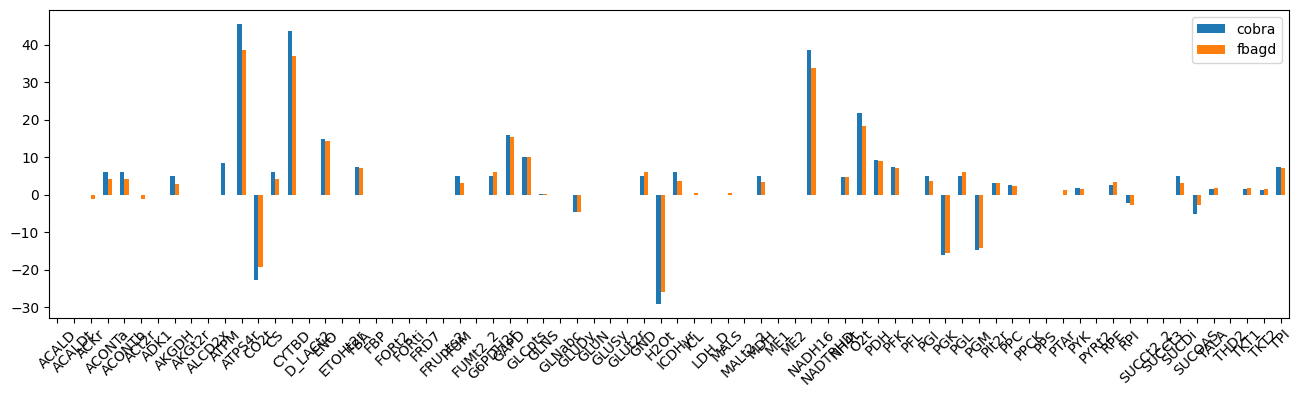

In [12]:
flux_df.plot.bar(figsize=(16,4),rot=45)

- Clearly correlated.
- Differences are consistent with the observations on exchange fluxes

#### Look in detail at fold differences

In [13]:
# Take advantage of the fact that none of the fbagd fluxes are exactly zero, and put it in the denominator
flux_df["diff"] = flux_df["cobra"] - flux_df["fbagd"]
flux_df["ratio"] = flux_df["cobra"] / flux_df["fbagd"]

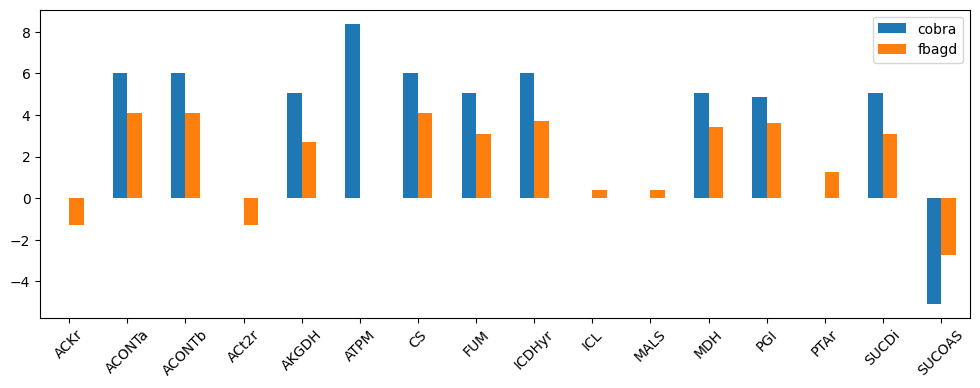

,cobra,fbagd,diff,ratio
ACKr,3.192215e-14,-1.269780,1.269780,-2.513990e-14
ACONTa,6.007250e+00,4.100888,1.906362,1.464866e+00
ACONTb,6.007250e+00,4.100888,1.906362,1.464866e+00
ACt2r,3.192215e-14,-1.269780,1.269780,-2.513990e-14
AKGDH,5.064376e+00,2.724660,2.339716,1.858718e+00
ATPM,8.390000e+00,0.024120,8.365880,3.478500e+02
CS,6.007250e+00,4.100888,1.906362,1.464866e+00
FUM,5.064376e+00,3.088004,1.976371,1.640016e+00
ICDHyr,6.007250e+00,3.728832,2.278417,1.611027e+00
ICL,0.000000e+00,0.372056,-0.372056,0.000000e+00


In [14]:
flux_df.loc[
    np.logical_and(flux_df["diff"].abs() > 0.2, (flux_df["ratio"] - 1).abs() > 0.3)
][["cobra", "fbagd"]].plot.bar(figsize=(12, 4), rot=45)
plt.show()

flux_df.loc[
    np.logical_and(flux_df["diff"].abs() > 0.2, (flux_df["ratio"] - 1).abs() > 0.3)
]

**OK** The big difference is ATPM. We can easily add that to the objective, though that begs the question, how does cobra force flux through that reaction?

Answer: it's in the bounds on the reaction itself. This gives us what we need to set it up as an objective.

In [15]:
flux_bounds = {}
for cobra_reaction in model.reactions:
    if cobra_reaction.lower_bound > 0 or cobra_reaction.upper_bound < 0:
        flux_bounds[reactions[cobra_reaction.id]] = cobra_reaction.bounds
print(flux_bounds)

{[ATPM] atp_c + h2o_c => adp_c + h_c + pi_c: (8.39, 1000.0)}


In [16]:
%%time
problem = fba_gd.FbaGd(
    network, intermediates, {
        "constraints": exchange_constraint,
        "required-flux": fba_gd.VelocityObjective(network, flux_bounds),
        "growth": biomass_objective,
    },
    w_fitness=1e6,
)
gd_soln = problem.solve()
print(gd_soln.fit)

1.5013827892937834e-12
CPU times: user 1.23 s, sys: 1.76 s, total: 2.99 s
Wall time: 836 ms


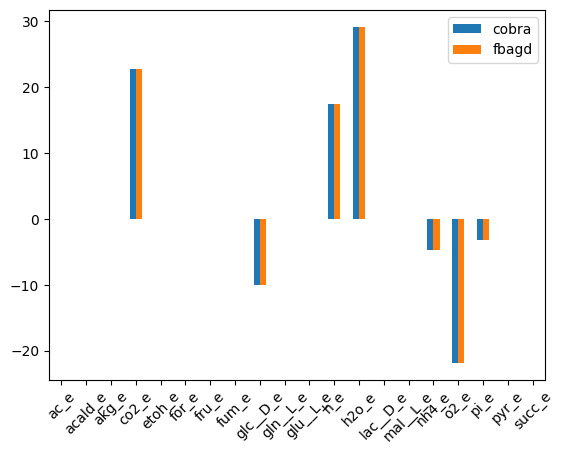

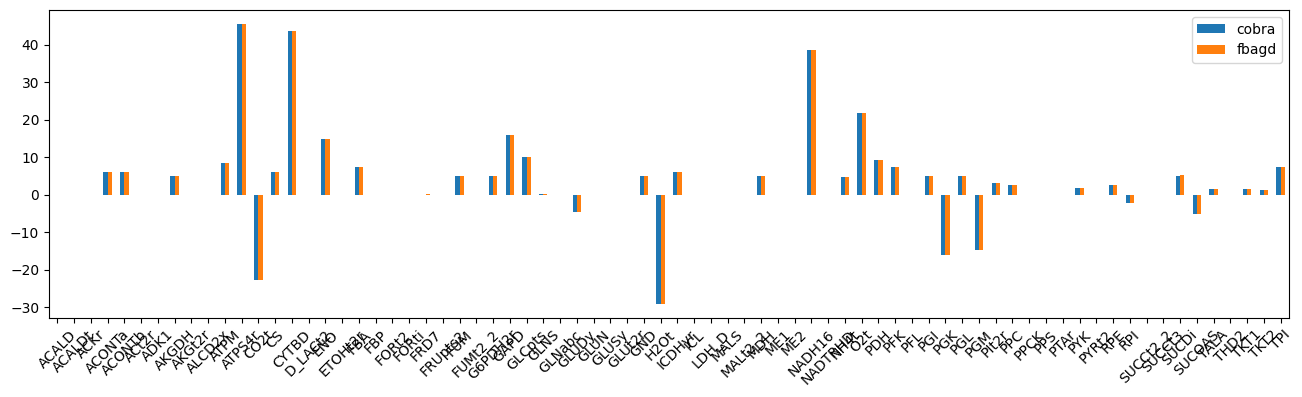

Significant differences:


,cobra,fbagd,diff,ratio
FRD7,0.000000,0.203081,-0.203081,0.000000
SUCDi,5.064376,5.267478,-0.203102,0.961442


In [17]:
fluxv_cobra = np.array(solution.fluxes[labels(network.reactions)])
fluxv_gd = gd_soln.velocities

flux_df = pd.DataFrame({
    rxn.id: {"cobra": flux_cobra, "fbagd": flux_gd}
    for rxn, flux_cobra, flux_gd in zip(network.reactions, fluxv_cobra, fluxv_gd)}).T
flux_df["diff"] = flux_df["cobra"] - flux_df["fbagd"]
flux_df["ratio"] = flux_df["cobra"] / flux_df["fbagd"]

dmdtv_cobra = network.s_matrix @ fluxv_cobra
dmdtv_gd = gd_soln.dmdt

dmdt_df = pd.DataFrame({
    mol.id: {"cobra": dmdt_cobra, "fbagd": dmdt_gd}
    for mol, dmdt_cobra, dmdt_gd in zip(network.reactants, dmdtv_cobra, dmdtv_gd)}).T
dmdt_df["diff"] = dmdt_df["cobra"] - dmdt_df["fbagd"]
dmdt_df["ratio"] = dmdt_df["cobra"] / dmdt_df["fbagd"]

dmdt_df.loc[labels(bounds.keys())][["cobra", "fbagd"]].plot.bar(rot=45)
flux_df[["cobra", "fbagd"]].plot.bar(figsize=(16,4),rot=45)
plt.show()

print("Significant differences:")
flux_df.loc[
    np.logical_and(flux_df["diff"].abs() > 0.01, (flux_df["ratio"] - 1).abs() > 0.01)
]

In [18]:
dmdt_df.describe()

,cobra,fbagd,diff,ratio
count,7.200000e+01,7.200000e+01,7.200000e+01,7.200000e+01
mean,-1.991330e-01,-1.991326e-01,-3.877139e-07,4.166681e-01
std,1.514598e+01,1.514598e+01,9.665169e-06,4.964655e-01
min,-5.226925e+01,-5.226925e+01,-5.225901e-05,-1.786608e-05
25%,-5.551115e-17,-3.021251e-07,7.875714e-09,-0.000000e+00
50%,0.000000e+00,-1.637916e-07,1.708114e-07,4.265583e-09
75%,7.465474e-02,7.465439e-02,2.849289e-07,1.000000e+00
max,5.226925e+01,5.226925e+01,4.812333e-05,1.000006e+00


In [19]:
flux_df.describe()

,cobra,fbagd,diff,ratio
count,74.000000,7.400000e+01,7.400000e+01,7.400000e+01
mean,2.959808,2.965316e+00,-5.508300e-03,5.400190e-01
std,10.776728,1.077657e+01,3.315549e-02,5.012912e-01
min,-29.175827,-2.917587e+01,-2.031024e-01,-8.532693e-09
25%,0.000000,-5.355412e-09,-1.046239e-05,0.000000e+00
50%,0.000000,4.911611e-07,-1.639352e-07,9.999956e-01
75%,5.064376,5.064397e+00,3.511705e-08,9.999991e-01
max,45.514010,4.551397e+01,5.225901e-05,1.000003e+00


In other words, more or less identical. Which is interesting, since it means there is no redundancy, no alternative paths to the same result. And no unconstrained futile cycles.

## Maximize growth as an objective

### First: what happens with growth rate on either side of the LP-determined optimum?

In [20]:
%%time
results = []
for delta in np.linspace(-.5, +.5, 21):
    # Set biomass targets proportional to adjusted growth rate
    growth = solution.objective_value + delta
    problem.update_params({"growth": {component: growth * amount for component, amount in biomass_components.items()}})
    results.append((growth, problem.solve()))

growthv = np.array([result[0] for result in results])
fluxv = np.array([result[1].velocities for result in results])
dmdtv = np.array([result[1].dmdt for result in results])

# Wow this is a lot of trouble...
residuals = {name: [] for name in problem.objectives.keys()}
for result in results:
    problem.update_params({"growth": {component: result[0] * amount for component, amount in biomass_components.items()}})
    for name, objective in problem.objectives.items():
        residuals[name].append(np.sum(np.square(objective.residual(result[1].velocities, result[1].dmdt, objective.params()))))    

CPU times: user 5.55 s, sys: 11.3 s, total: 16.8 s
Wall time: 2.22 s


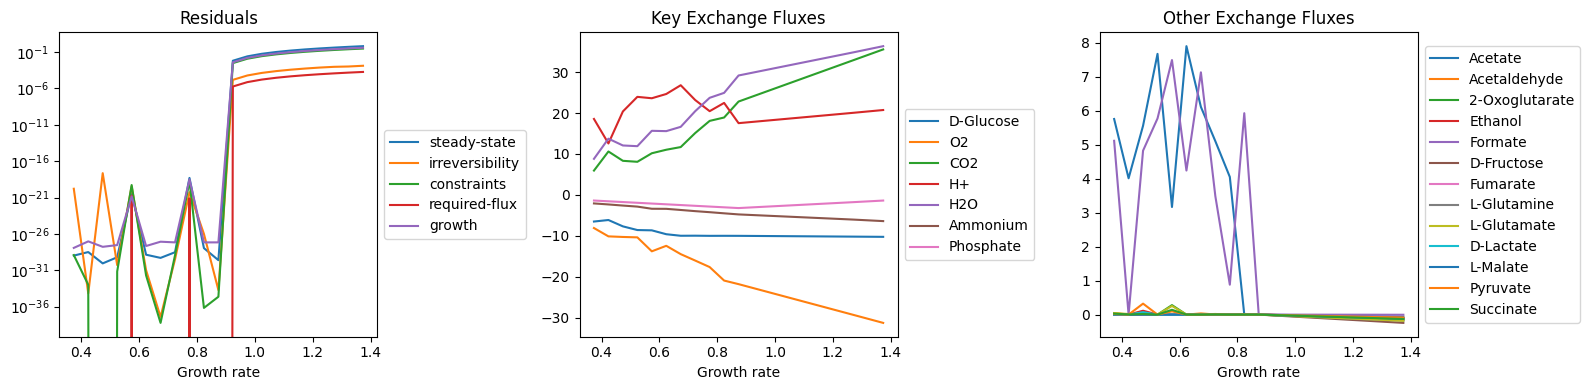

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

for name, scores in residuals.items():
    ax[0].plot(growthv, scores, label=name)
ax[0].set_yscale("log")
# ax[0].set_ylim(1e-12, 1e0)
ax[0].set_title("Residuals")
ax[0].set_xlabel("Growth rate")
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

key_species = [mols[id] for id in ("glc__D_e", "o2_e", "co2_e", "h_e", "h2o_e", "nh4_e", "pi_e")]
for mol in key_species:
    ax[1].plot(growthv, dmdtv[:, network.reactants.index_of(mol)], label=mol.name)
ax[1].set_title("Key Exchange Fluxes")
ax[1].set_xlabel("Growth rate")
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

for mol in bounds:
    if mol not in key_species:
        ax[2].plot(growthv, dmdtv[:, network.reactants.index_of(mol)], label=mol.name)
ax[2].set_title("Other Exchange Fluxes")
ax[2].set_xlabel("Growth rate")
ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()
plt.show()

- Fit error jumps sharply at the LP optimimum, this is a good sign
- Glucose uptake increases steadily until the optimimum, then flattens
- Solutions are variable up to the optimum, more tightly constrained after that
    - This includes secreting e.g. Formate or Acetate, which are absent from the optimal solution
- In the faster growth solutions, the ratios of CO2, O2, H+ and H2O in/out change
    - Specifically, O2 -> CO2 increases more rapidly than H2O or H+. Interpret this as shifting from OxPhos to other ATP production?

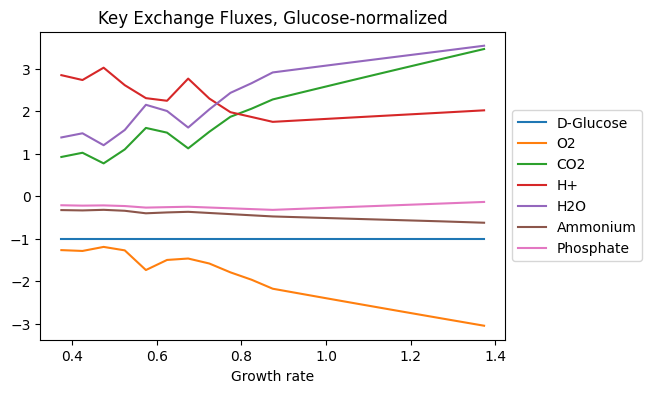

In [23]:
glc_normalized = (dmdtv.T / -dmdtv.T[network.reactants.index_of(mols["glc__D_e"])]).T
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

for mol in key_species:
    ax.plot(growthv, glc_normalized[:, network.reactants.index_of(mol)], label=mol.name)
ax.set_title("Key Exchange Fluxes, Glucose-normalized")
ax.set_xlabel("Growth rate")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

### Finer scale near optimal growth rate

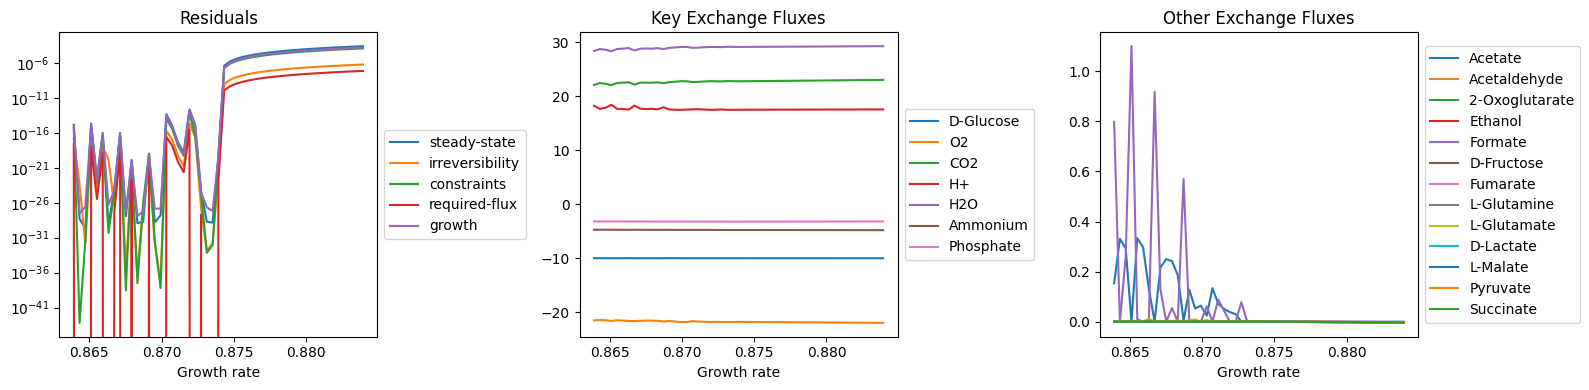

In [25]:
results = []
for delta in np.linspace(-.01, +.01, 51):
    # Set biomass targets proportional to adjusted growth rate
    growth = solution.objective_value + delta
    problem.update_params({"growth": {component: growth * amount for component, amount in biomass_components.items()}})
    results.append((growth, problem.solve()))

growthv = np.array([result[0] for result in results])
fluxv = np.array([result[1].velocities for result in results])
dmdtv = np.array([result[1].dmdt for result in results])

residuals = {name: [] for name in problem.objectives.keys()}
for result in results:
    problem.update_params({"growth": {component: result[0] * amount for component, amount in biomass_components.items()}})
    for name, objective in problem.objectives.items():
        residuals[name].append(np.sum(np.square(objective.residual(result[1].velocities, result[1].dmdt, objective.params()))))

fig, ax = plt.subplots(1, 3, figsize=(16, 4))

for name, scores in residuals.items():
    ax[0].plot(growthv, scores, label=name)
ax[0].set_yscale("log")
# ax[0].set_ylim(1e-12, 1e0)
ax[0].set_title("Residuals")
ax[0].set_xlabel("Growth rate")
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

key_species = [mols[id] for id in ("glc__D_e", "o2_e", "co2_e", "h_e", "h2o_e", "nh4_e", "pi_e")]
for mol in key_species:
    ax[1].plot(growthv, dmdtv[:, network.reactants.index_of(mol)], label=mol.name)
ax[1].set_title("Key Exchange Fluxes")
ax[1].set_xlabel("Growth rate")
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

for mol in bounds:
    if mol not in key_species:
        ax[2].plot(growthv, dmdtv[:, network.reactants.index_of(mol)], label=mol.name)
ax[2].set_title("Other Exchange Fluxes")
ax[2].set_xlabel("Growth rate")
ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()
plt.show()

### Strategies
- If we lump everything into one objective function, we need to weight minimizing error _way_ higher than maximizing growth. This uses the jump in the first graph as a hard stop not to push growth higher. Even at fine scale, this error gradient is very steep. We should be able to take advantage of that.
- Other possible signals (maybe not as sharp as the error signal)
    - Use glucose uptake not as a limit, but as an exact target. Justification: matching an observed quantity
    - Also put targets on low or zero secretion of acetate, formate, maybe others. Jusification: efficient growth
    - Constrain ratios of glucose, O2, CO2, water
- Alternative: Constrain biomass _ratios_, but do not explicitly maximize growth. With some of the other constaints above this may guide us to the same transition point without having to arbitrarily balance maximizing growth vs minimizing error in the objective

### Explicitly maximize growth
- Since we are not pushing an error to zero, but pushing growth rate to a non-zero maximum, we need to rebuild the whole approach around minimize() instead of least_squares()
    - If this is successful of course we can build this into FbaGd
- Underweight contribution of growth rate, but make it significant enough to overcome fluctuation in the 'fitness' objectives.

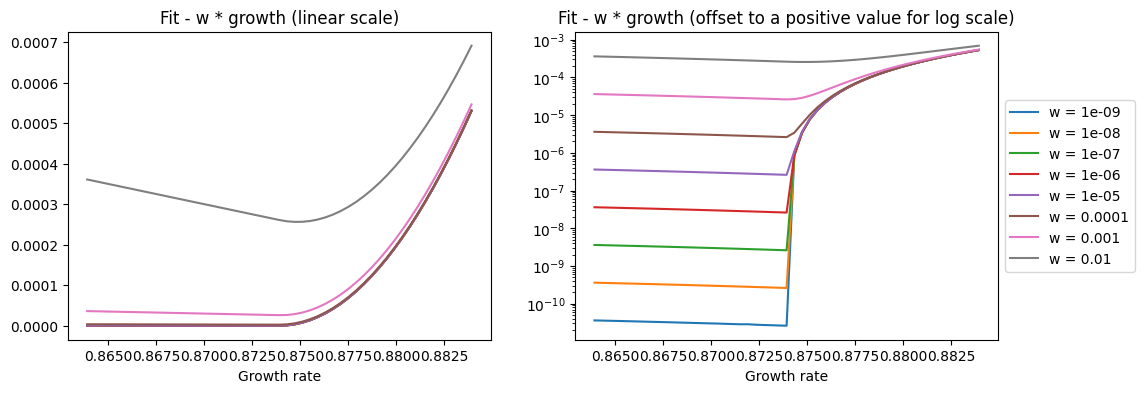

In [26]:
fitv = np.array([scores for scores in residuals.values()]).sum(axis=0)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for w in [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]:
    ax[0].plot(growthv, fitv - growthv * w + w * 0.9, label=f"w = {w}")
    ax[1].plot(growthv, fitv - growthv * w + w * 0.9, label=f"w = {w}")
ax[0].set_xlabel("Growth rate")
ax[1].set_xlabel("Growth rate")
ax[0].set_title("Fit - w * growth (linear scale)")
ax[1].set_title("Fit - w * growth (offset to a positive value for log scale)")
ax[1].set_yscale("log")
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

- At higher weights, the left-side gradient is steeper but the minimum is noticeably shifted right
- At lower weights the transition is sharp and at the desired optimum, but the left-side gradient may be too shallow, or not smooth enough

In [27]:
ss_constraint = problem.objectives["steady-state"]
irreversibility_constraint = problem.objectives["irreversibility"]
flux_objective = problem.objectives["required-flux"]

# Shape (2, #components) with upper and lower bounds equal
biomass_fractions = jnp.array([biomass_components[network.reactants[i]] for i in biomass_objective.indices]) * jnp.array([[1.], [1.]])

# Residuals to drive to zero via sum of squares
def fitness_residual(growth, fluxv):
    dmdt = network.s_matrix @ fluxv
    
    ss_residual = ss_constraint.residual(fluxv, dmdt)
    irreversibility_residual = irreversibility_constraint.residual(fluxv, dmdt)
    exchange_residual = exchange_constraint.residual(fluxv, dmdt, exchange_constraint.bounds)
    flux_residual = flux_objective.residual(fluxv, dmdt, flux_objective.bounds)
    biomass_residual = biomass_objective.residual(fluxv, dmdt, growth * biomass_fractions)

    return jnp.concatenate([ss_residual, irreversibility_residual, exchange_residual, flux_residual, biomass_residual])

# Variable vector to optimize is the growth rate, followed by the full velocity vector
w = 5e-3
def objective_min(x):
    growth = x[0]
    fluxv = x[1:]
    return jnp.sum(jnp.square(fitness_residual(growth, fluxv))) - w * growth

fn_jit = jax.jit(objective_min)
fn_jac = jax.jit(jax.jacfwd(objective_min))

In [28]:
%%time
seed = jax.random.PRNGKey(int(time.time() * 1000))
x0 = jax.random.normal(seed, (1 + problem.network.shape[1],))

soln = scipy.optimize.minimize(
    fun=fn_jit,
    x0=x0, 
    jac=fn_jac)

gdgrowth = soln.x[0]
fluxv = soln.x[1:]
dmdt = network.s_matrix @ fluxv

fit_residual = np.concatenate(
    [problem.objectives[name].residual(fluxv, dmdt, None) for name in ['steady-state', 'irreversibility']])

gd_soln = fba_gd.FbaResult(v0=np.asarray(x0[1:]),
                                         velocities=np.asarray(fluxv),
                                         dmdt=np.asarray(dmdt),
                                         fit=float(np.sum(np.square(fit_residual))))
print(gdgrowth, gd_soln.fit)

0.8727251142232353 5.697928651653369e-07
CPU times: user 1.23 s, sys: 0 ns, total: 1.23 s
Wall time: 1.24 s


Empirically, weights less than ~0.05 fall substantially short of the desired optimum, while weights greater than ~0.1 clearly overshoot. In any case the result is variable depending on the starting point for optimization. Works fast though.

### Add a constraint to target glucose uptake and minimize secretion of acetate and formate

In [29]:
profile_targets = fba_gd.ProductionObjective(network, {mols["glc__D_e"]: -10, mols["ac_e"]: 0, mols["for_e"]: 0, mols["lac__D_e"]: 0})

# Residuals to drive to zero via sum of squares
def fitness_residual(growth, fluxv):
    dmdt = network.s_matrix @ fluxv
    
    ss_residual = ss_constraint.residual(fluxv, dmdt)
    irreversibility_residual = irreversibility_constraint.residual(fluxv, dmdt)
    exchange_residual = exchange_constraint.residual(fluxv, dmdt, exchange_constraint.bounds)
    flux_residual = flux_objective.residual(fluxv, dmdt, flux_objective.bounds)
    profile_residual = profile_targets.residual(fluxv, dmdt, profile_targets.bounds)
    biomass_residual = biomass_objective.residual(fluxv, dmdt, growth * biomass_fractions)

    return jnp.concatenate([ss_residual, irreversibility_residual, exchange_residual, flux_residual, profile_residual, biomass_residual])

# Variable vector to optimize is the growth rate, followed by the full velocity vector
w = 1e-3
def objective_min(x):
    growth = x[0]
    fluxv = x[1:]
    return jnp.sum(jnp.square(fitness_residual(growth, fluxv))) - w * growth

fn_jit = jax.jit(objective_min)
fn_jac = jax.jit(jax.jacfwd(objective_min))

In [30]:
%%time
seed = jax.random.PRNGKey(int(time.time() * 1000))
x0 = jax.random.normal(seed, (1 + problem.network.shape[1],))

soln = scipy.optimize.minimize(
    fun=fn_jit,
    x0=x0, 
    jac=fn_jac)

gdgrowth = soln.x[0]
fluxv = soln.x[1:]
dmdt = network.s_matrix @ fluxv

fit_residual = np.concatenate(
    [problem.objectives[name].residual(fluxv, dmdt, None) for name in ['steady-state', 'irreversibility']])

gd_soln = fba_gd.FbaResult(v0=np.asarray(x0[1:]),
                                         velocities=np.asarray(fluxv),
                                         dmdt=np.asarray(dmdt),
                                         fit=float(np.sum(np.square(fit_residual))))
print(gdgrowth, gd_soln.fit)

0.8542288549764283 2.1148171336555724e-08
CPU times: user 1.13 s, sys: 8.26 ms, total: 1.14 s
Wall time: 1.14 s


I was hoping these constraints would drive it toward optimal growth so we could underweight the contribution of growth _per se_. Not much difference really, though.

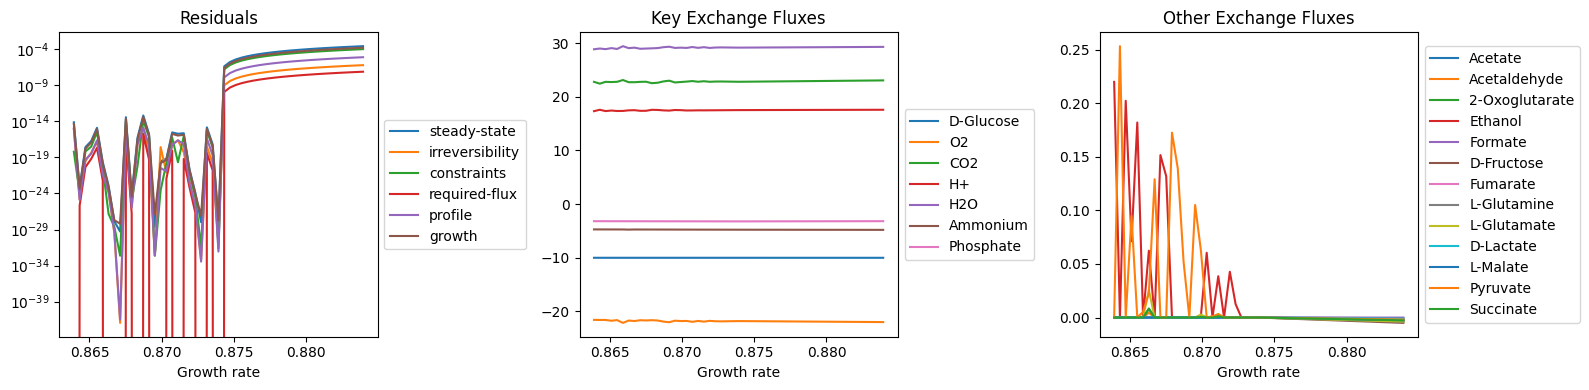

CPU times: user 15.9 s, sys: 29.8 s, total: 45.8 s
Wall time: 6.65 s


In [34]:
%%time
problem = fba_gd.FbaGd(
    network, intermediates, {
        "constraints": exchange_constraint,
        "required-flux": fba_gd.VelocityObjective(network, flux_bounds),
        "profile": profile_targets,
        "growth": biomass_objective,
    },
    w_fitness=1e6,
)

results = []
for delta in np.linspace(-.01, +.01, 51):
    # Set biomass targets proportional to adjusted growth rate
    growth = solution.objective_value + delta
    problem.update_params({"growth": {component: growth * amount for component, amount in biomass_components.items()}})
    results.append((growth, problem.solve()))

growthv = np.array([result[0] for result in results])
fluxv = np.array([result[1].velocities for result in results])
dmdtv = np.array([result[1].dmdt for result in results])

residuals = {name: [] for name in problem.objectives.keys()}
for result in results:
    problem.update_params({"growth": {component: result[0] * amount for component, amount in biomass_components.items()}})
    for name, objective in problem.objectives.items():
        residuals[name].append(np.sum(np.square(objective.residual(result[1].velocities, result[1].dmdt, objective.params()))))

fig, ax = plt.subplots(1, 3, figsize=(16, 4))

for name, scores in residuals.items():
    ax[0].plot(growthv, scores, label=name)
ax[0].set_yscale("log")
# ax[0].set_ylim(1e-12, 1e0)
ax[0].set_title("Residuals")
ax[0].set_xlabel("Growth rate")
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

key_species = [mols[id] for id in ("glc__D_e", "o2_e", "co2_e", "h_e", "h2o_e", "nh4_e", "pi_e")]
for mol in key_species:
    ax[1].plot(growthv, dmdtv[:, network.reactants.index_of(mol)], label=mol.name)
ax[1].set_title("Key Exchange Fluxes")
ax[1].set_xlabel("Growth rate")
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

for mol in bounds:
    if mol not in key_species:
        ax[2].plot(growthv, dmdtv[:, network.reactants.index_of(mol)], label=mol.name)
ax[2].set_title("Other Exchange Fluxes")
ax[2].set_xlabel("Growth rate")
ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()
plt.show()

- Random additional observation: If we force 0 acetate or formate, it secretes lactate. Block that and it secretes ethanol or acetaldehyde. We appear to be reconstructing overflow metabolism.

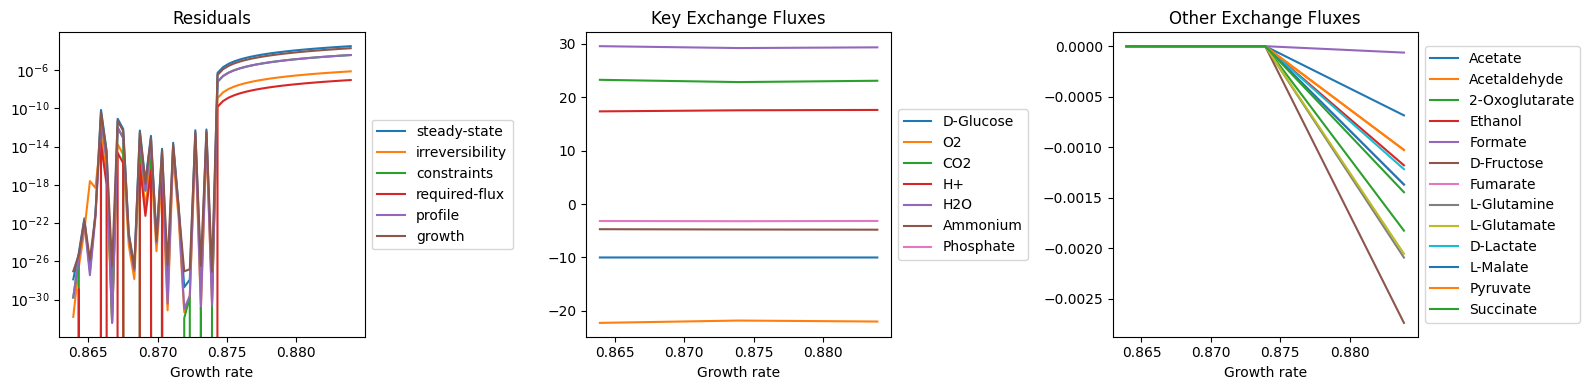

In [35]:
clean_profile = {mol: 0 for mol in bounds if mol not in key_species}
clean_profile[mols["glc__D_e"]] = -10
problem = fba_gd.FbaGd(
    network, intermediates, {
        "constraints": exchange_constraint,
        "required-flux": fba_gd.VelocityObjective(network, flux_bounds),
        "profile": fba_gd.ProductionObjective(network, clean_profile),
        "growth": biomass_objective,
    },
    w_fitness=1e6,
)

results = []
for delta in np.linspace(-.01, +.01, 51):
    # Set biomass targets proportional to adjusted growth rate
    growth = solution.objective_value + delta
    problem.update_params({"growth": {component: growth * amount for component, amount in biomass_components.items()}})
    results.append((growth, problem.solve()))

growthv = np.array([result[0] for result in results])
fluxv = np.array([result[1].velocities for result in results])
dmdtv = np.array([result[1].dmdt for result in results])

residuals = {name: [] for name in problem.objectives.keys()}
for result in results:
    problem.update_params({"growth": {component: result[0] * amount for component, amount in biomass_components.items()}})
    for name, objective in problem.objectives.items():
        residuals[name].append(np.sum(np.square(objective.residual(result[1].velocities, result[1].dmdt, objective.params()))))

fig, ax = plt.subplots(1, 3, figsize=(16, 4))

for name, scores in residuals.items():
    ax[0].plot(growthv, scores, label=name)
ax[0].set_yscale("log")
# ax[0].set_ylim(1e-12, 1e0)
ax[0].set_title("Residuals")
ax[0].set_xlabel("Growth rate")
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

key_species = [mols[id] for id in ("glc__D_e", "o2_e", "co2_e", "h_e", "h2o_e", "nh4_e", "pi_e")]
for mol in key_species:
    ax[1].plot(growthv, dmdtv[:, network.reactants.index_of(mol)], label=mol.name)
ax[1].set_title("Key Exchange Fluxes")
ax[1].set_xlabel("Growth rate")
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

for mol in bounds:
    if mol not in key_species:
        ax[2].plot(growthv, dmdtv[:, network.reactants.index_of(mol)], label=mol.name)
ax[2].set_title("Other Exchange Fluxes")
ax[2].set_xlabel("Growth rate")
ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()
plt.show()

Man, nothing is giving a gradient on the left-hand side except for growth rate itself.

## Different Tack: constrained minimization

### Linear constraints based on flux or dmdt
- Really does work easiest if biomass is a column appended to the S matrix. It's just not a reaction per se.

In [36]:
# irreversibility and required_flux translate simply to bounds on flux vector
lb_flux = []
ub_flux = []
for reaction in network.reactions:
    # Basic constraint for reversibility
    lb = -np.inf if reaction.reversible else 0
    ub = np.inf
    # Override where specified--this is really only for ATPM here...
    if reaction in flux_bounds:
        lb, ub = flux_bounds[reaction]
    
    lb_flux.append(lb)
    ub_flux.append(ub)

# Append 0 <= growth < inf at the end of the flux vector
lb_flux.append(0)
ub_flux.append(np.inf)
lconst_flux = scipy.optimize.Bounds(lb_flux, ub_flux)

# steady-state and exhange constraints translate to bounds on dmdt, i.e. s_matrix @ fluxv
lb_dmdt = []
ub_dmdt = []
for reactant in network.reactants:
    if reactant in bounds:
        lb, ub = bounds[reactant]
        if lb == -1000:
            lb = -np.inf
        if ub == 1000:
            ub = np.inf
        lb_dmdt.append(lb)
        ub_dmdt.append(ub)
    else:
        # This includes biomass components, since we include it in fluxv and s_matix
        lb_dmdt.append(0)
        ub_dmdt.append(0)

s_extended = np.concatenate([network.s_matrix, -network.reactants.pack(biomass_components).reshape((network.shape[0], 1))], axis=1)
lconst_dmdt = scipy.optimize.LinearConstraint(s_extended, lb_dmdt, ub_dmdt)

In [37]:
seed = jax.random.PRNGKey(int(time.time() * 1000))
x0 = jax.random.normal(seed, (1 + network.shape[1],))

def growth_fun(x):
    return -x[-1]

soln = scipy.optimize.minimize(
    fun=jax.jit(growth_fun),
    x0=x0,
    method='trust-constr',
    jac=jax.jit(jax.jacfwd(growth_fun)),
    hess=jax.jit(jax.hessian(growth_fun)),
    bounds=lconst_flux,
    constraints=[lconst_dmdt],
    options={"verbose": 1},
)

/home/fdrusso/.pyenv/versions/3.8.16/envs/notebooks/lib/python3.8/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +


The maximum number of function evaluations is exceeded.
Number of iterations: 1000, function evaluations: 1000, CG iterations: 1000, optimality: 8.07e-02, constraint violation: 7.36e+00, execution time: 1.4e+01 s.


In [38]:
s_extended

array([[-1.    ,  1.    ,  0.    , ...,  0.    ,  0.    , -0.    ],
       [-1.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  3.7478],
       [-1.    ,  0.    ,  0.    , ...,  0.    ,  0.    , -3.547 ],
       ...,
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    , -0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    , -0.    ],
       [ 0.    ,  0.    ,  0.    , ..., -1.    ,  0.    , -0.361 ]])

### Propotional constraint (for biomass)